In [2]:
import os
import pandas as pd

def load_bm25_data(root_folder):
    bm25_data = {}

    # Iterate through the retriever folders
    for retriever_folder in os.listdir(root_folder):
        retriever_path = os.path.join(root_folder, retriever_folder)

        # Check if it's a directory
        if os.path.isdir(retriever_path):
            retriever_data = {}

            # Iterate through language folders (de, en, etc.)
            for lang_folder in os.listdir(retriever_path):
                lang_path = os.path.join(retriever_path, lang_folder)

                # Check if it's a directory
                if os.path.isdir(lang_path):
                    index_data = {}

                    # Iterate through index folders
                    for index_folder in os.listdir(lang_path):
                        index_path = os.path.join(lang_path, index_folder)

                        # Check if it's a directory
                        if os.path.isdir(index_path):
                            # Load all CSV files in the index folder
                            index_files = {}
                            for csv_file in os.listdir(index_path):
                                if csv_file.endswith('.csv'):
                                    csv_path = os.path.join(index_path, csv_file)
                                    df = pd.read_csv(csv_path)
                                    index_files[csv_file] = df

                            index_data[index_folder] = index_files

                    retriever_data[lang_folder] = index_data

            bm25_data[retriever_folder] = retriever_data

    # Concatenate the DataFrames within the nested dictionary
    for retriever, retriever_data in bm25_data.items():
        for lang, lang_data in retriever_data.items():
            for index, index_files in lang_data.items():
                concatenated_df = pd.concat(index_files.values(), ignore_index=True)
                
                # Sort the DataFrame based on the "k" column
                concatenated_df = concatenated_df.sort_values(by='k')
                
                # Reset the index
                concatenated_df = concatenated_df.reset_index(drop=True)

                bm25_data[retriever][lang][index] = concatenated_df

    return bm25_data

root_folder = "./benchmarks-retriever"

# Load the BM25 data
data = load_bm25_data(root_folder)

# Access the concatenated, sorted, and reset index DataFrame for BM25 retriever, language 'de', index 'translated_IndexEnglishAll'
df_combined_sorted = data['bm25']['de']['translated_IndexEnglishAll']
print(df_combined_sorted)

   Retriever     k        HR       MRR
0       BM25     1  0.183295  0.183295
1       BM25     3  0.283473  0.227119
2       BM25     5  0.331586  0.238078
3       BM25    10  0.402085  0.247408
4       BM25    15  0.449383  0.251129
5       BM25    25  0.514843  0.254438
6       BM25    50  0.610612  0.257162
7       BM25   100  0.702672  0.258492
8       BM25   150  0.742715  0.258823
9       BM25   200  0.768902  0.258974
10      BM25   300  0.802740  0.259113
11      BM25   400  0.823531  0.259174
12      BM25   500  0.840124  0.259211
13      BM25  1000  0.884777  0.259276


In [3]:
data

{'dpr': {'de': {'translated_IndexEnglishAll':    Retriever     k        HR       MRR
   0   largeDPR     1  0.300796  0.300796
   1   largeDPR     3  0.439959  0.362059
   2   largeDPR     5  0.502232  0.376290
   3   largeDPR    10  0.586524  0.387556
   4   largeDPR    15  0.638004  0.391613
   5   largeDPR    25  0.703348  0.394939
   6   largeDPR    50  0.793301  0.397506
   7   largeDPR   100  0.874887  0.398697
   8   largeDPR   150  0.903959  0.398938
   9   largeDPR   200  0.920427  0.399033
   10  largeDPR   300  0.938948  0.399109
   11  largeDPR   400  0.950183  0.399142
   12  largeDPR   500  0.957656  0.399159
   13  largeDPR  1000  0.973681  0.399182,
   'IndexGermanAll':    Retriever     k        HR       MRR
   0   largeDPR     1  0.235225  0.235225
   1   largeDPR     3  0.342329  0.282504
   2   largeDPR     5  0.389765  0.293309
   3   largeDPR    10  0.459314  0.302535
   4   largeDPR    15  0.500956  0.305811
   5   largeDPR    25  0.556726  0.308630
   6   largeDP

In [4]:
def post_process_bm25_data(data):
    new_bm25_data = data.copy()

    # Iterate through the retriever folders
    for retriever, retriever_data in data.items():
        if retriever.startswith('bm25_ce'):
            new_retriever_data = {}
            for lang, lang_data in retriever_data.items():
                new_lang_data = {}
                for index, df in lang_data.items():
                    # Add a new column "k_inner" to the DataFrame
                    df['k_inner'] = df['Retriever'].str.split('-CE-k').str[0].str.split('-k').str[1].astype(int)
                    new_lang_data[index] = df.copy()  # Copy the modified DataFrame
                new_retriever_data[lang] = new_lang_data
            new_bm25_data[retriever] = new_retriever_data

    # Return the new dictionary
    return new_bm25_data


In [5]:
bm25_data = load_bm25_data(root_folder)

In [6]:
bm25_data_post_processed = post_process_bm25_data(bm25_data)

In [7]:
def group_and_rename(data):
    new_data = data.copy()

    for language, language_data in data['bm25_ce'].copy().items():
        for index_name, index_data in language_data.items():
            if isinstance(index_data, pd.DataFrame):
                for index, retriever_data in index_data.groupby('k_inner'):
                    retriever_name = f'bm25_ce_{index}'

                    # Ensure the necessary keys exist before accessing/modifying
                    if retriever_name not in new_data:
                        new_data[retriever_name] = {}
                    if language not in new_data[retriever_name]:
                        new_data[retriever_name][language] = {}
                    if index_name not in new_data[retriever_name][language]:
                        new_data[retriever_name][language][index_name] = {}

                    new_data[retriever_name][language][index_name] = retriever_data

                # Remove the old key
                # del new_data['bm25_ce'][language][index_name]

    return new_data

In [8]:
bm25_grouped = group_and_rename(bm25_data_post_processed)

In [9]:
bm25_grouped.keys()

dict_keys(['dpr', 'bm25_ce', 'bm25', 'bm25_ce_1', 'bm25_ce_3', 'bm25_ce_5', 'bm25_ce_10', 'bm25_ce_15', 'bm25_ce_25', 'bm25_ce_50', 'bm25_ce_100', 'bm25_ce_150', 'bm25_ce_200', 'bm25_ce_300', 'bm25_ce_400', 'bm25_ce_500', 'bm25_ce_1000'])

In [10]:
bm25_grouped['bm25_ce_1000']['en']['IndexEnglishAll']

,Retriever,k,HR,MRR,k_inner
7,BM25-k1000-CE-k1,1,0.289670,0.289670,1000
21,BM25-k1000-CE-k3,3,0.412333,0.343724,1000
35,BM25-k1000-CE-k5,5,0.468588,0.356579,1000
46,BM25-k1000-CE-k10,10,0.553105,0.367850,1000


In [11]:
bm25_grouped.keys()

dict_keys(['dpr', 'bm25_ce', 'bm25', 'bm25_ce_1', 'bm25_ce_3', 'bm25_ce_5', 'bm25_ce_10', 'bm25_ce_15', 'bm25_ce_25', 'bm25_ce_50', 'bm25_ce_100', 'bm25_ce_150', 'bm25_ce_200', 'bm25_ce_300', 'bm25_ce_400', 'bm25_ce_500', 'bm25_ce_1000'])

In [12]:
bm25_grouped['dpr']['en']['IndexEnglishAll'].columns

Index(['Retriever', 'k', 'HR', 'MRR'], dtype='object')

In [13]:
data = bm25_grouped

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
bm25_grouped['dpr'].keys()

dict_keys(['de', 'en'])

In [16]:
print(bm25_grouped['dpr']["en"].keys())
print(bm25_grouped['dpr']["de"].keys())

dict_keys(['IndexEnglishAll', 'translated_IndexGermanAll'])
dict_keys(['translated_IndexEnglishAll', 'IndexGermanAll'])


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_indices_comparison(bm25_grouped, selected_retrievers, selected_indices, metric='HR', max_k=None):
    # Extracting data for specified retrievers and all languages
    indices = set()
    for retriever in selected_retrievers:
        for lang in bm25_grouped[retriever]:
            indices.update(bm25_grouped[retriever][lang].keys())

    # Filter indices based on selected_indices
    indices = [index for index in indices if index in selected_indices]

    # Set seaborn style
    sns.set(style="darkgrid")

    # Create a color palette with distinct colors for each index
    palette = sns.color_palette("husl", n_colors=len(indices))

    # Define line styles based on the number of selected retrievers
    line_styles = ['solid', 'dotted', 'dashed', 'dashdot'] * (len(selected_retrievers) // 4 + 1)

    # Plotting
    plt.figure(figsize=(10, 6))

    for i, index in enumerate(indices):
        for j, retriever in enumerate(selected_retrievers):
            for lang in bm25_grouped[retriever]:
                if index in bm25_grouped[retriever][lang]:
                    data = bm25_grouped[retriever][lang][index]

                    # Apply max_k if provided
                    if max_k is not None:
                        data = data[data['k'] <= max_k]

                    # Use uppercase retriever names for consistency
                    sns.lineplot(x='k', y=metric, data=data, label=f'{retriever.upper()} - {index} ({lang})', color=palette[i], linestyle=line_styles[j % len(line_styles)])
                    plt.scatter(data['k'], data[metric], color=palette[i], marker='o', s=20)  # Add dots on the line at data points

    # Set labels and title dynamically
    retriever_str = ', '.join(selected_retrievers)
    # Full CAPS for retriever names
    retriever_str = retriever_str.upper()
    index_str = ', '.join(selected_indices)
    max_k_str = f', Max k = {max_k}' if max_k is not None else ''

    # Check if more than 2 retrievers are selected
    if len(selected_retrievers) > 2:
        retriever_str = 'multiple'
    
    if len(selected_indices) > 2:
        index_str = 'multiple'

    plt.xlabel('k')
    plt.ylabel(metric)
    
    # Add space below the title
    plt.title(f'{metric} for {retriever_str} retriever over {index_str} indices{max_k_str}', pad=20)

    # Add legend
    plt.legend()

    # Add space below the graph
    plt.subplots_adjust(bottom=0.15)

    # Show the plot
    plt.show()


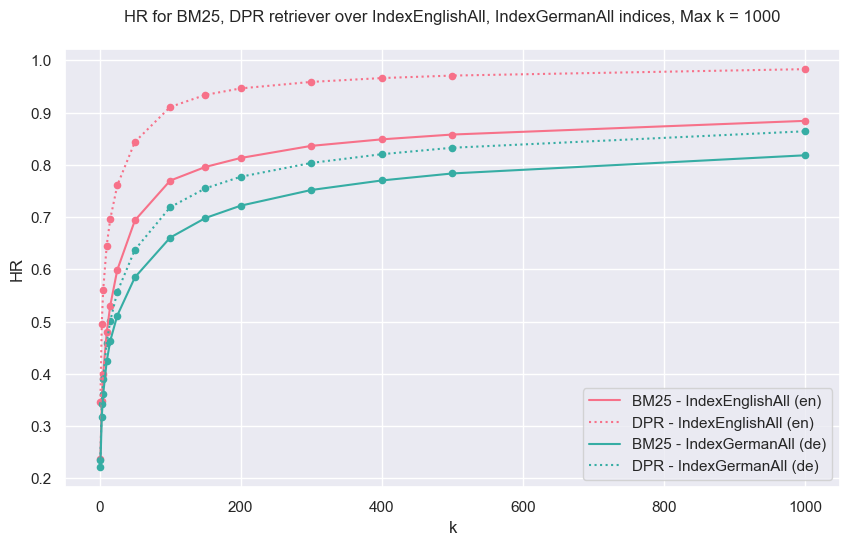

In [18]:
# Graph 1
# Welcher Retriever performt am besten bei k=1000

plot_indices_comparison(bm25_grouped, ['bm25', 'dpr'], ['IndexEnglishAll', "IndexGermanAll"], metric='HR', max_k=1000)

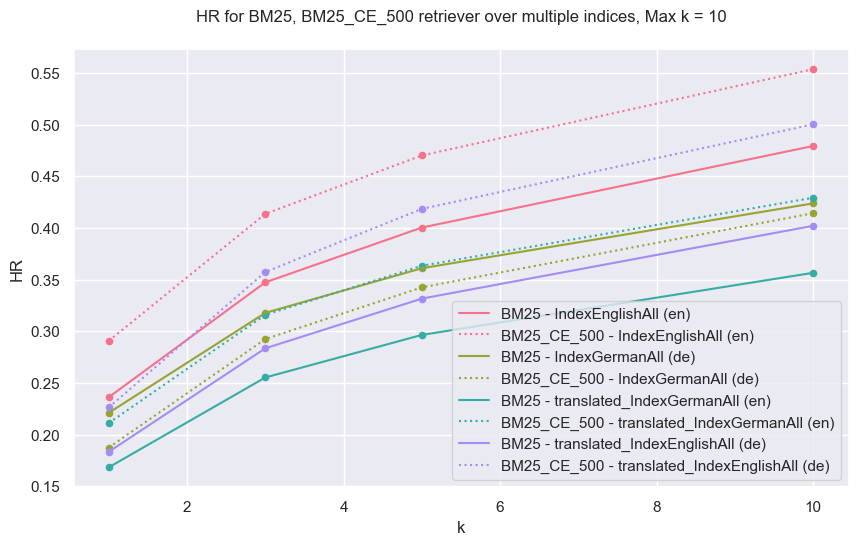

In [19]:
# Graph 2
# Warum Ensemble Retrieval besser ist als BM25

plot_indices_comparison(bm25_grouped, ['bm25', 'bm25_ce_500'], ['IndexEnglishAll', "IndexGermanAll", "translated_IndexEnglishAll", "translated_IndexGermanAll"], metric='HR', max_k=10)

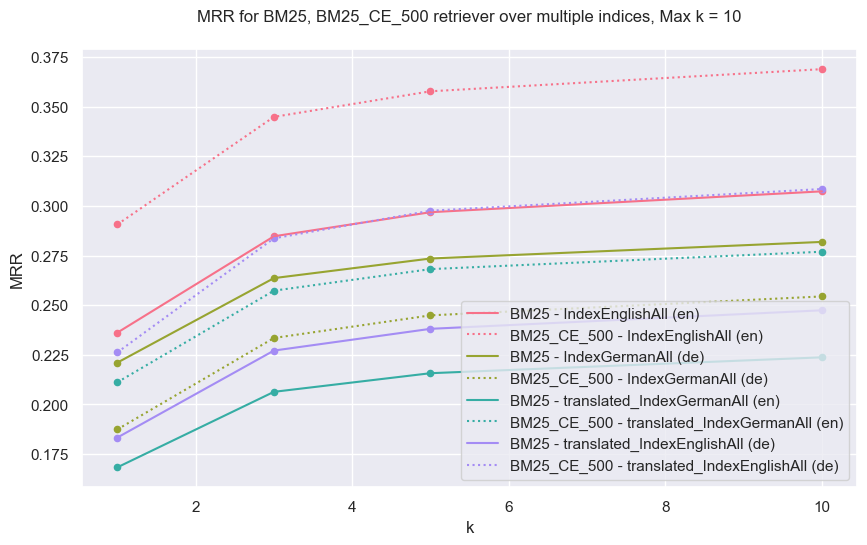

In [20]:
# Graph 3
# Warum Ensemble Retrieval besser ist als BM25

plot_indices_comparison(bm25_grouped, ['bm25', 'bm25_ce_500'], ['IndexEnglishAll', "IndexGermanAll", "translated_IndexEnglishAll", "translated_IndexGermanAll"], metric='MRR', max_k=10)

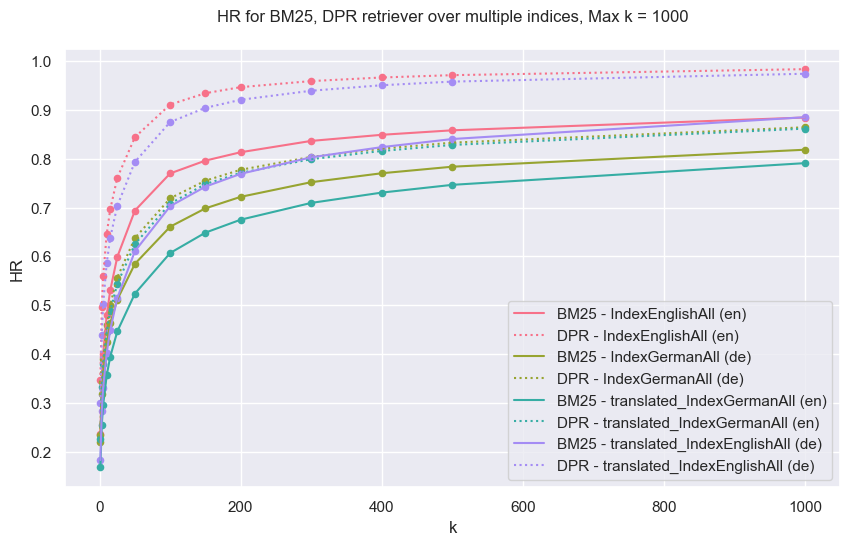

In [21]:
# Graph 4
# Unterschied zwischen Sprachen?

plot_indices_comparison(bm25_grouped, ['bm25', 'dpr'], ['IndexEnglishAll', "translated_IndexEnglishAll", "IndexGermanAll", "translated_IndexGermanAll"], metric='HR', max_k=1000)

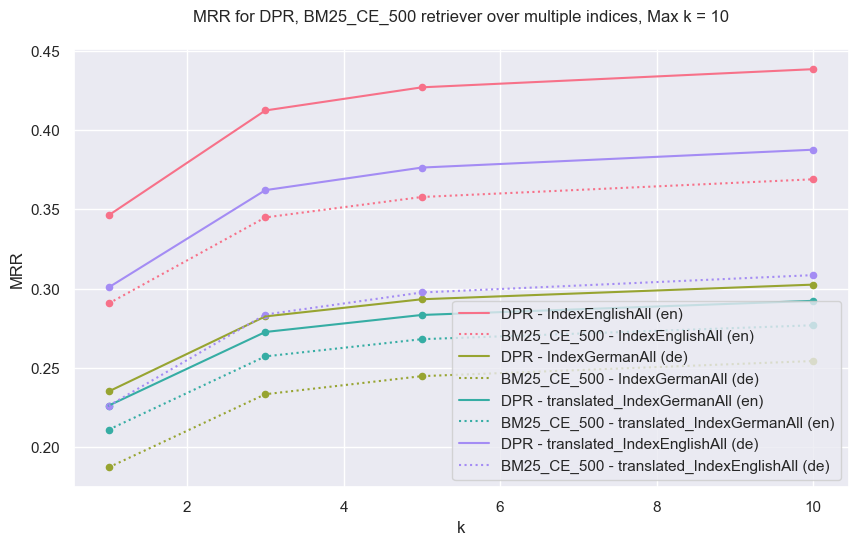

In [22]:
# Graph 5
# Welcher ist der beste Retriever für den Use-Case?

plot_indices_comparison(bm25_grouped, ['dpr', 'bm25_ce_500'], ['IndexEnglishAll', "IndexGermanAll", "translated_IndexEnglishAll", "translated_IndexGermanAll"], metric='MRR', max_k=10)

In [23]:
bm25_grouped.keys()

dict_keys(['dpr', 'bm25_ce', 'bm25', 'bm25_ce_1', 'bm25_ce_3', 'bm25_ce_5', 'bm25_ce_10', 'bm25_ce_15', 'bm25_ce_25', 'bm25_ce_50', 'bm25_ce_100', 'bm25_ce_150', 'bm25_ce_200', 'bm25_ce_300', 'bm25_ce_400', 'bm25_ce_500', 'bm25_ce_1000'])

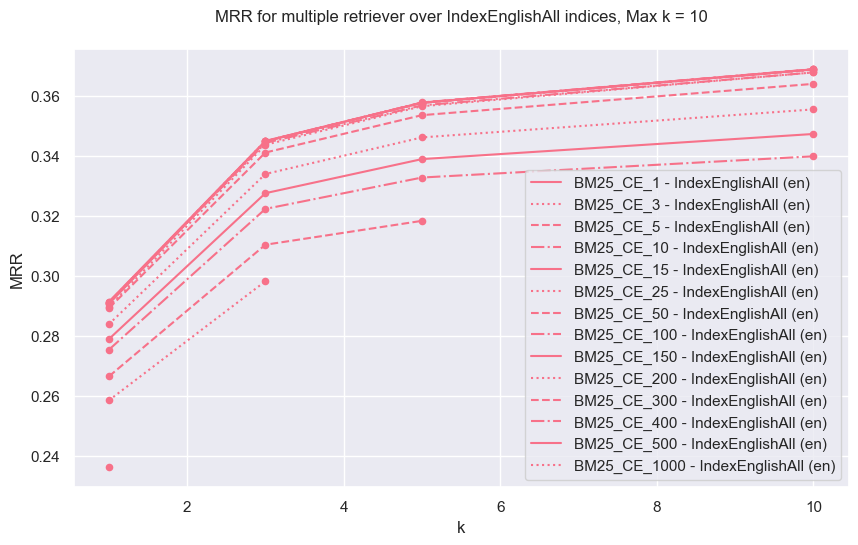

In [24]:
plot_indices_comparison(bm25_grouped, ['bm25_ce_1', 'bm25_ce_3', 'bm25_ce_5', 'bm25_ce_10', 'bm25_ce_15', 'bm25_ce_25', 'bm25_ce_50', 'bm25_ce_100', 'bm25_ce_150', 'bm25_ce_200', 'bm25_ce_300', 'bm25_ce_400', 'bm25_ce_500', 'bm25_ce_1000'], ['IndexEnglishAll'], metric='MRR', max_k=10)

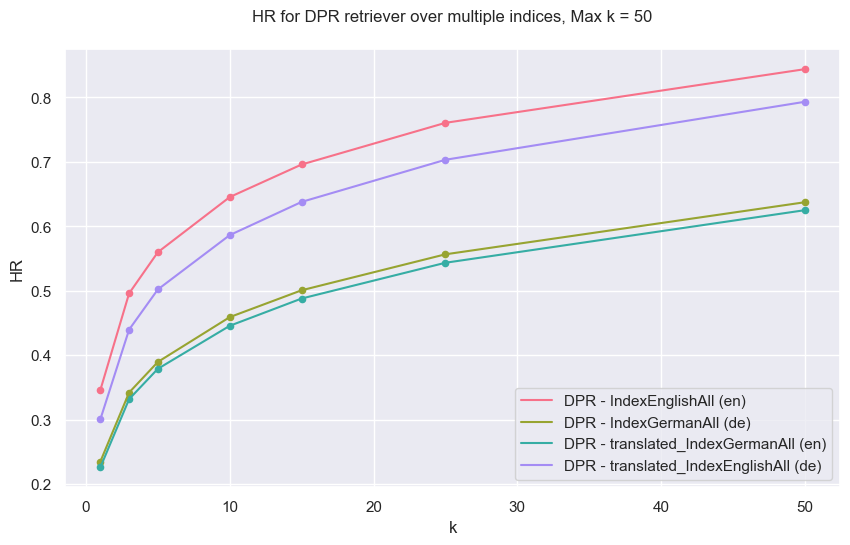

In [25]:
# Graph 6 (For Data Generation Evaluation)
# Was ist der Qualitätsunterschied zwischen den Indices?

plot_indices_comparison(bm25_grouped, ['dpr'], ['IndexEnglishAll', "IndexGermanAll", "translated_IndexEnglishAll", "translated_IndexGermanAll"], metric='HR', max_k=50)

In [26]:
def plot_indices_comparison(bm25_grouped, selected_retrievers, selected_indices, metric='HR', max_k=None, consistent_line_style=False):

    # Extracting data for specified retrievers and all languages
    indices = set()
    for retriever in selected_retrievers:
        for lang in bm25_grouped[retriever]:
            indices.update(bm25_grouped[retriever][lang].keys())

    # Filter indices based on selected_indices
    indices = [index for index in indices if index in selected_indices]

    # Set seaborn style
    sns.set(style="darkgrid")

    # Create a color palette with distinct colors for each index
    palette = sns.color_palette("husl", n_colors=len(selected_retrievers))

    # Define line style if consistent_line_style is True
    line_style = 'solid' if consistent_line_style else None

    # Plotting
    plt.figure(figsize=(10, 6))

    for i, index in enumerate(indices):
        for j, retriever in enumerate(selected_retrievers):
            for lang in bm25_grouped[retriever]:
                if index in bm25_grouped[retriever][lang]:
                    data = bm25_grouped[retriever][lang][index]

                    # Apply max_k if provided
                    if max_k is not None:
                        data = data[data['k'] <= max_k]

                    # Use uppercase retriever names for consistency
                    sns.lineplot(x='k', y=metric, data=data, label=f'{retriever.upper()} - {index} ({lang})', color=palette[j], linestyle=line_style)
                    plt.scatter(data['k'], data[metric], color=palette[j], marker='o', s=20)  # Add dots on the line at data points

    # Set labels and title dynamically
    retriever_str = ', '.join(selected_retrievers)
    # Full CAPS for retriever names
    retriever_str = retriever_str.upper()
    index_str = ', '.join(selected_indices)
    max_k_str = f', Max k = {max_k}' if max_k is not None else ''

    # Check if more than 2 retrievers are selected
    if len(selected_retrievers) > 2:
        retriever_str = 'multiple'
    
    if len(selected_indices) > 2:
        index_str = 'multiple'

    plt.xlabel('k')
    plt.ylabel(metric)
    
    # Add space below the title
    plt.title(f'{metric} for {retriever_str} retriever over {index_str} indices{max_k_str}', pad=20)

    # Add legend
    plt.legend()

    # Add space below the graph
    plt.subplots_adjust(bottom=0.15)

    # Show the plot
    plt.show()

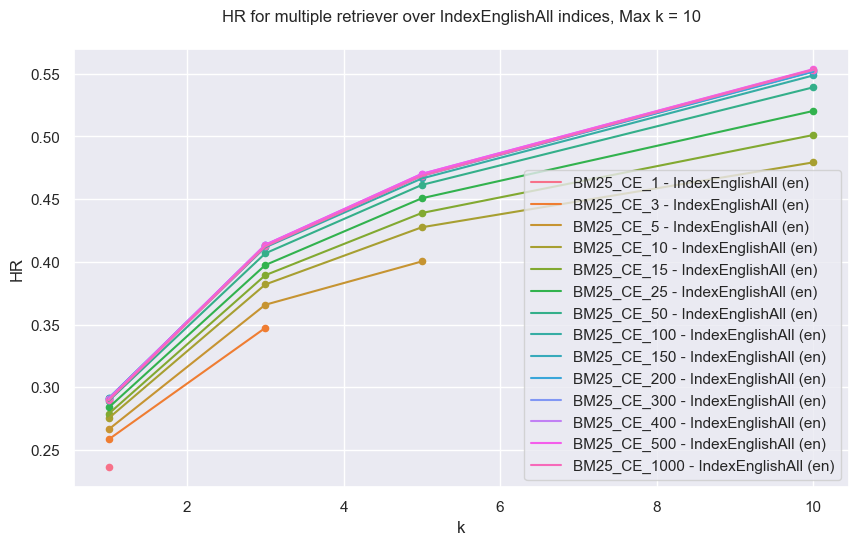

In [27]:
plot_indices_comparison(bm25_grouped, ['bm25_ce_1', 'bm25_ce_3', 'bm25_ce_5', 'bm25_ce_10', 'bm25_ce_15', 'bm25_ce_25', 'bm25_ce_50', 'bm25_ce_100', 'bm25_ce_150', 'bm25_ce_200', 'bm25_ce_300', 'bm25_ce_400', 'bm25_ce_500', 'bm25_ce_1000'], ['IndexEnglishAll'], metric='HR', max_k=10, consistent_line_style=True)

In [28]:
import pandas as pd

def generate_table(bm25_grouped, selected_retrievers, selected_indices, metrics=['HR'], max_k=None):
    # Extracting data for specified retrievers and all languages
    data_list = []

    for retriever in selected_retrievers:
        for lang in bm25_grouped[retriever]:
            for index in selected_indices:
                if index in bm25_grouped[retriever][lang]:
                    data = bm25_grouped[retriever][lang][index]

                    # Apply max_k if provided
                    if max_k is not None:
                        data = data[data['k'] <= max_k]

                    # Prepare metric data for the selected metrics
                    for _, row in data.iterrows():
                        for metric in metrics:
                            if metric in data:
                                metric_data = {'k': row['k'],
                                               'retriever': retriever.upper(),
                                               'index': index,
                                               'metric': metric,
                                               'value': row[metric] if metric in row else None}
                                data_list.append(metric_data)

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data_list)
    
    # Generate a pivot table with the columns in the order: index, metric, retriever
    df_pivot = pd.pivot_table(df, index='k', columns=['index', 'metric', 'retriever'], values='value')

    return df_pivot

In [29]:
bm25_grouped.keys()

dict_keys(['dpr', 'bm25_ce', 'bm25', 'bm25_ce_1', 'bm25_ce_3', 'bm25_ce_5', 'bm25_ce_10', 'bm25_ce_15', 'bm25_ce_25', 'bm25_ce_50', 'bm25_ce_100', 'bm25_ce_150', 'bm25_ce_200', 'bm25_ce_300', 'bm25_ce_400', 'bm25_ce_500', 'bm25_ce_1000'])

In [33]:
table_data = generate_table(bm25_grouped, ["dpr", "bm25_ce_500", "bm25_ce_1000"], ["IndexEnglishAll", "IndexGermanAll","translated_IndexEnglishAll", "translated_IndexGermanAll"], metrics=['HR',"MRR"], max_k=10)
print(table_data)

index     IndexEnglishAll                                                 \
metric                 HR                                MRR               
retriever    BM25_CE_1000 BM25_CE_500       DPR BM25_CE_1000 BM25_CE_500   
k                                                                          
1                0.289670    0.290665  0.346251     0.289670    0.290665   
3                0.412333    0.413632  0.496136     0.343724    0.344858   
5                0.468588    0.470151  0.560026     0.356579    0.357755   
10               0.553105    0.553665  0.645523     0.367850    0.368904   

index               IndexGermanAll                                     ...  \
metric                          HR                                MRR  ...   
retriever       DPR   BM25_CE_1000 BM25_CE_500       DPR BM25_CE_1000  ...   
k                                                                      ...   
1          0.346251       0.183031    0.187395  0.235225     0.183031  ...   
3

In [34]:
table_data.to_latex(multirow=True, multicolumn=True)

'\\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrr}\n\\toprule\nindex & \\multicolumn{6}{r}{IndexEnglishAll} & \\multicolumn{6}{r}{IndexGermanAll} & \\multicolumn{4}{r}{translated_IndexEnglishAll} & \\multicolumn{6}{r}{translated_IndexGermanAll} \\\\\nmetric & \\multicolumn{3}{r}{HR} & \\multicolumn{3}{r}{MRR} & \\multicolumn{3}{r}{HR} & \\multicolumn{3}{r}{MRR} & \\multicolumn{2}{r}{HR} & \\multicolumn{2}{r}{MRR} & \\multicolumn{3}{r}{HR} & \\multicolumn{3}{r}{MRR} \\\\\nretriever & BM25_CE_1000 & BM25_CE_500 & DPR & BM25_CE_1000 & BM25_CE_500 & DPR & BM25_CE_1000 & BM25_CE_500 & DPR & BM25_CE_1000 & BM25_CE_500 & DPR & BM25_CE_500 & DPR & BM25_CE_500 & DPR & BM25_CE_1000 & BM25_CE_500 & DPR & BM25_CE_1000 & BM25_CE_500 & DPR \\\\\nk &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\\\\n\\midrule\n1 & 0.289670 & 0.290665 & 0.346251 & 0.289670 & 0.290665 & 0.346251 & 0.183031 & 0.187395 & 0.235225 & 0.183031 & 0.187395 & 0.235225 & 0.226215 & 0.300796 & 0.226215 & 0.300796 & 0

In [129]:
import os

def print_folder_structure(root_folder, indent=0):
    # Print the current folder with proper indentation
    print("  " * indent + f"{root_folder}/")

    # Traverse through all the files and subfolders in the current folder
    for item in os.listdir(root_folder):
        item_path = os.path.join(root_folder, item)

        # Check if it's a file or a subfolder
        if os.path.isfile(item_path):
            print("  " * (indent + 1) + f"{item}")
        elif os.path.isdir(item_path):
            # Recursively call the function for subfolders
            print_folder_structure(item_path, indent + 1)

root_folder = "./benchmarks-reader"

print_folder_structure(root_folder=root_folder)

./benchmarks-reader/
  ./benchmarks-reader/de/
    ./benchmarks-reader/de/translated_IndexEnglishAll_short/
      ./benchmarks-reader/de/translated_IndexEnglishAll_short/LeoLama-2-7B/
        ./benchmarks-reader/de/translated_IndexEnglishAll_short/LeoLama-2-7B/qac_extended/
          ./benchmarks-reader/de/translated_IndexEnglishAll_short/LeoLama-2-7B/qac_extended/7/
            ./benchmarks-reader/de/translated_IndexEnglishAll_short/LeoLama-2-7B/qac_extended/7/True/
              LeoLama-2-7B_translated_IndexEnglishAll_short_qac_extended_metrics.json
            ./benchmarks-reader/de/translated_IndexEnglishAll_short/LeoLama-2-7B/qac_extended/7/False/
              LeoLama-2-7B_translated_IndexEnglishAll_short_qac_extended_metrics.json
          ./benchmarks-reader/de/translated_IndexEnglishAll_short/LeoLama-2-7B/qac_extended/1/
            ./benchmarks-reader/de/translated_IndexEnglishAll_short/LeoLama-2-7B/qac_extended/1/False/
              LeoLama-2-7B_translated_IndexEnglishAll_s

In [35]:
import os
import json

def load_reader_data(root_folder, selected_indices=[]):
    metric_data = {}

    # Iterate through the language folders
    for language_folder in os.listdir(root_folder):
        language_folder_path = os.path.join(root_folder, language_folder)

        for index in os.listdir(language_folder_path):
            if index in selected_indices:
                index_path = os.path.join(language_folder_path, index)

                for reader in os.listdir(index_path):
                    reader_path = os.path.join(index_path, reader)

                    for dataset in os.listdir(reader_path):
                        dataset_path = os.path.join(reader_path, dataset)

                        for context_length in os.listdir(dataset_path):
                            context_length_path = os.path.join(dataset_path, context_length)

                            for random_shuffle in os.listdir(context_length_path):
                                random_shuffle_path = os.path.join(context_length_path, random_shuffle)

                                for metric_file in os.listdir(random_shuffle_path):
                                    if metric_file.endswith('.json'):
                                        metric_file_path = os.path.join(random_shuffle_path, metric_file)

                                        # Read JSON file into a dictionary
                                        with open(metric_file_path, 'r') as json_file:
                                            data = json.load(json_file)

                                        # Build the nested dictionary structure
                                        if reader not in metric_data:
                                            metric_data[reader] = {}
                                        if language_folder not in metric_data[reader]:
                                            metric_data[reader][language_folder] = {}
                                        if index not in metric_data[reader][language_folder]:
                                            metric_data[reader][language_folder][index] = {}
                                        if dataset not in metric_data[reader][language_folder][index]:
                                            metric_data[reader][language_folder][index][dataset] = {}
                                        if context_length not in metric_data[reader][language_folder][index][dataset]:
                                            metric_data[reader][language_folder][index][dataset][context_length] = {}
                                        if random_shuffle not in metric_data[reader][language_folder][index][dataset][context_length]:
                                            metric_data[reader][language_folder][index][dataset][context_length][random_shuffle] = data

    return metric_data

# Example usage:
root_folder = "./benchmarks-reader"
data = load_reader_data(root_folder, selected_indices=["IndexGermanAll_short", "IndexEnglishAll_short", "translated_IndexGermanAll_short", "translated_IndexEnglishAll_short"])

# Access the loaded data, for example:
# metric_value = data.get("reader_name", {}).get("language_folder", {}).get("index", {}).get("dataset", {}).get("context_length", {}).get("random_shuffle", {})


In [36]:
data["LeoLama-2-7B"]["de"]["IndexGermanAll_short"]["qac_extended"]["1"]["False"]["all"]["bertscore"]["f1"]

[0.7191243171691895,
 0.7113692164421082,
 0.6122596263885498,
 0.7320110201835632,
 0.653370201587677,
 0.7368485927581787,
 0.6022166013717651,
 0.543110191822052,
 0.6702700853347778,
 0.553707480430603,
 0.5598475933074951,
 0.696081280708313,
 0.6900593042373657,
 0.5817462205886841,
 0.6344919800758362,
 0.7261525392532349,
 0.6430837512016296,
 0.7791121602058411,
 0.6255505084991455,
 0.6471928954124451,
 0.6673696637153625,
 0.7847688794136047,
 0.7272902727127075,
 0.7399303913116455,
 0.6276872754096985,
 0.7926389575004578,
 0.7043963074684143,
 0.7387523055076599,
 0.7103331685066223,
 0.6978318095207214,
 0.6096867918968201,
 0.7230745553970337,
 0.6179141998291016,
 0.571858823299408,
 0.7941072583198547,
 0.6657266020774841,
 0.7826679348945618,
 0.6623275876045227,
 0.6293622851371765,
 0.6246420741081238,
 0.6443539261817932,
 0.7229573130607605,
 0.6500278115272522,
 0.6017685532569885,
 0.8268947005271912,
 0.635644793510437,
 0.7747634649276733,
 0.6108956933021545

In [37]:
# All relevant metric settings

# Blue

metric_keys = ["blue", "bleu"]

# Rouge
metric_keys = ["rouge", "rougeL"]

# BertScore
metric_keys = ["bertscore", "f1"]

# LLM Accuracy
metric_keys = ["llm_accuracy", "accuracy"]

In [45]:
import numpy as np
import seaborn as sns

def generate_lineplot(data, selected_indices, selected_readers, random_shuffles, dropped_or_all, language, selected_datasets, metric_keys, min_context_length=None, max_context_length=None):
    """
    Generate a line plot using Seaborn.

    Parameters:
    - data (dict): The data dictionary.
    - filters (list): List of filters to apply to the data dictionary.
    - metric_keys (list): List of metric keys to use for the x-axis.

    Returns:
    - None (displays the plot).
    """

    # Filter the data based on provided filters
    filtered_data = []
    for reader in selected_readers:
        if reader not in data:
            continue
        for lang in language:
            if lang not in data[reader]:
                continue
            for index in selected_indices:
                if index not in data[reader][lang]:
                    continue
                for dataset in selected_datasets:
                    if dataset not in data[reader][lang][index]:
                        continue
                    possible_data = data[reader][lang][index][dataset]
                    existing_context_length = [int(i) for i in possible_data.keys() if (min_context_length is None or int(i) >= min_context_length) and (max_context_length is None or int(i) <= max_context_length)]
                    for context_length in existing_context_length:
                        for random_shuffle in random_shuffles:
                            if random_shuffle not in possible_data[str(context_length)]:
                                continue
                            for dropped_or_all_iter in dropped_or_all:
                                if dropped_or_all_iter not in possible_data[str(context_length)][random_shuffle]:
                                    continue
                                metric_value = possible_data[str(context_length)][random_shuffle][dropped_or_all_iter]
                                for sub_key in metric_keys:
                                    if sub_key not in metric_value:
                                        continue
                                    metric_value = metric_value[sub_key]
                                    if metric_value == "None":
                                        metric_value = None
                                        break
                                    if sub_key == "f1":
                                        metric_value = np.mean(metric_value)
                                    
                                df_entry = {
                                "reader": reader,
                                    "language": lang,
                                    "index": index,
                                    "dataset": dataset,
                                    "context_length": context_length,
                                    "random_shuffle": random_shuffle,
                                    "dropped_or_all": dropped_or_all_iter,
                                    metric_keys[-1] : metric_value 
                                }
                                filtered_data.append(df_entry)
    df = pd.DataFrame(filtered_data)

    # Create a new column that combines all the filters with more than one unique value
    filter_columns = [col for col in df.columns if df[col].nunique() > 1 and col != metric_keys[-1] and col != 'context_length']
    df['displayed lines'] = df[filter_columns].apply(lambda row: ' - '.join(row.values.astype(str)), axis=1)

    # Generate the line plot
    plt.figure(figsize=(10, 6))
    # Generate the line plot
    sns.lineplot(y=metric_keys[-1], x="context_length", hue="displayed lines", data=df, marker="o")

    # Add title with some space
    plt.title('Line plot of ' + metric_keys[-1] + ' over context length', y=1.05)

    # Create a box "filters" that states the settings of all the parameters which have only 1 value
    filter_settings = [f"{col}: {df[col].unique()[0]}" for col in df.columns if df[col].nunique() == 1 and col != "dataset"]
    filter_text = "Filters:\n" + "\n".join(filter_settings)
    plt.text(0.95, 0.01, filter_text, verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize='x-small')

    plt.show()

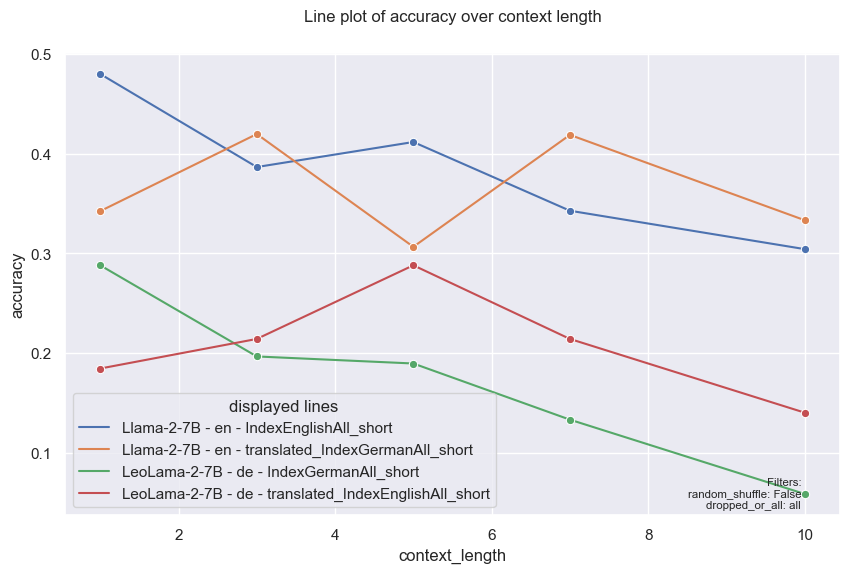

In [46]:

selected_indices = [ "IndexEnglishAll_short", "IndexGermanAll_short", "translated_IndexEnglishAll_short", "translated_IndexGermanAll_short"]
selected_readers = ["Llama-2-7B", "LeoLama-2-7B"]
random_shuffles = ["False"]
dropped_or_all = ["all"]
language = ["en", "de"]
selected_datasets = ["qac_extended"]

metric_keys = ["llm_accuracy", "accuracy"]  # Only one metric key is needed for the x-axis
generate_lineplot(data, selected_indices=selected_indices, selected_readers=selected_readers, random_shuffles=random_shuffles, dropped_or_all=dropped_or_all, language=language, selected_datasets=selected_datasets, metric_keys=metric_keys)

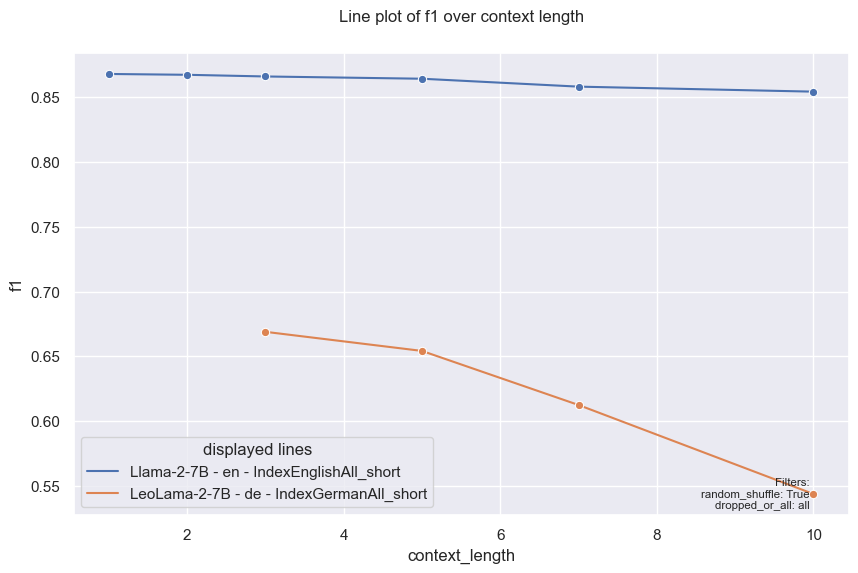

In [47]:
# Graph 1
# How many context passages will still lead to a correct answer?

selected_indices = [ "IndexEnglishAll_short", "IndexGermanAll_short"]
selected_readers = ["Llama-2-7B", "LeoLama-2-7B"]
random_shuffles = ["True"]
dropped_or_all = ["all"]
language = ["en", "de"]
selected_datasets = ["qac_extended"]

# metric_keys = ["llm_accuracy", "accuracy"]  # Only one metric key is needed for the x-axis
metric_keys = ["bertscore", "f1"]
generate_lineplot(data, selected_indices=selected_indices, selected_readers=selected_readers, random_shuffles=random_shuffles, dropped_or_all=dropped_or_all, language=language, selected_datasets=selected_datasets, metric_keys=metric_keys)

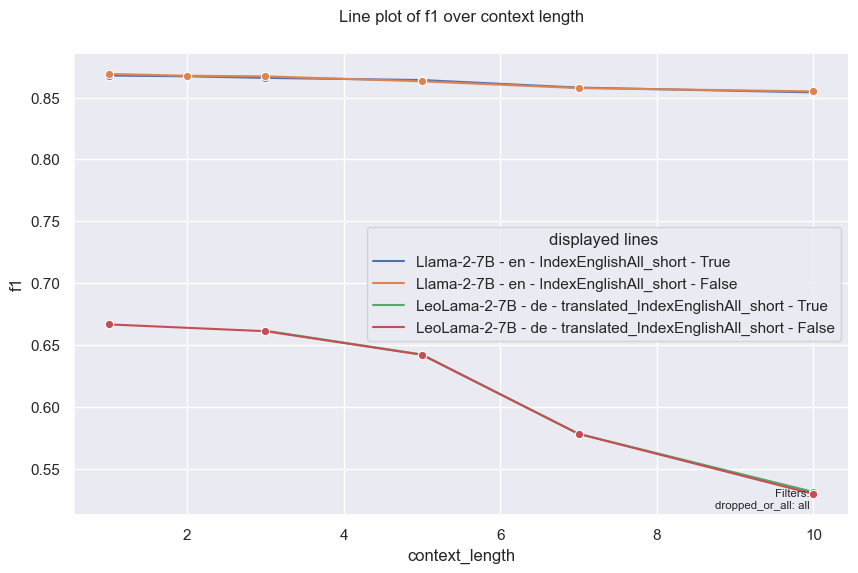

In [48]:
# Graph 2 (A - BertscoreF1)
# Is the order of the contexts important?

selected_indices = [ "IndexEnglishAll_short", "translated_IndexEnglishAll_short"]
selected_readers = ["Llama-2-7B", "LeoLama-2-7B"]
random_shuffles = ["True", "False"]
dropped_or_all = ["all"]
language = ["en", "de"]
selected_datasets = ["qac_extended"]

# metric_keys = ["llm_accuracy", "accuracy"]  # Only one metric key is needed for the x-axis
# Use Bertscore F1
metric_keys = ["bertscore", "f1"]  # Only one metric key is needed for the x-axis
generate_lineplot(data, selected_indices=selected_indices, selected_readers=selected_readers, random_shuffles=random_shuffles, dropped_or_all=dropped_or_all, language=language, selected_datasets=selected_datasets, metric_keys=metric_keys)

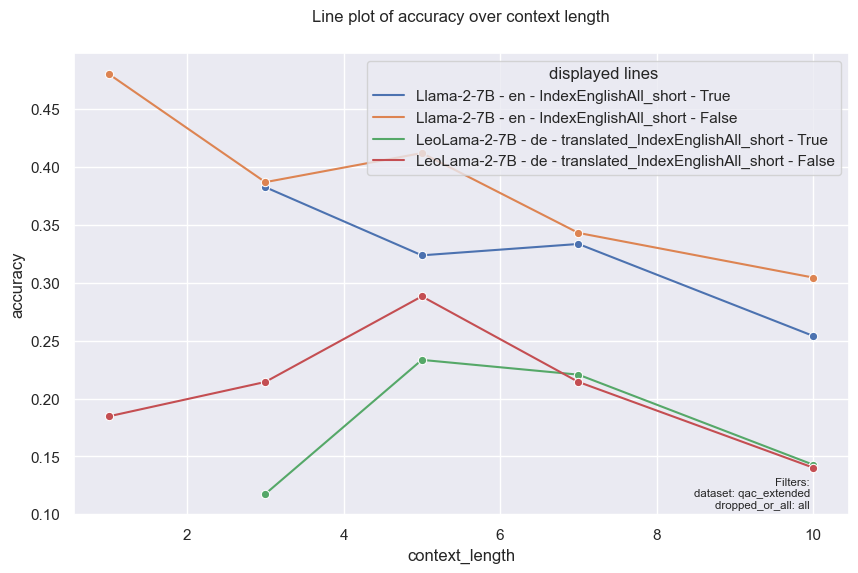

In [42]:
# Graph 2 (B - LLM Accuracy)
# Is the order of the contexts important?

selected_indices = [ "IndexEnglishAll_short", "translated_IndexEnglishAll_short"]
selected_readers = ["Llama-2-7B", "LeoLama-2-7B"]
random_shuffles = ["True", "False"]
dropped_or_all = ["all"]
language = ["en", "de"]
selected_datasets = ["qac_extended"]

metric_keys = ["llm_accuracy", "accuracy"]  # Only one metric key is needed for the x-axis
generate_lineplot(data, selected_indices=selected_indices, selected_readers=selected_readers, random_shuffles=random_shuffles, dropped_or_all=dropped_or_all, language=language, selected_datasets=selected_datasets, metric_keys=metric_keys)

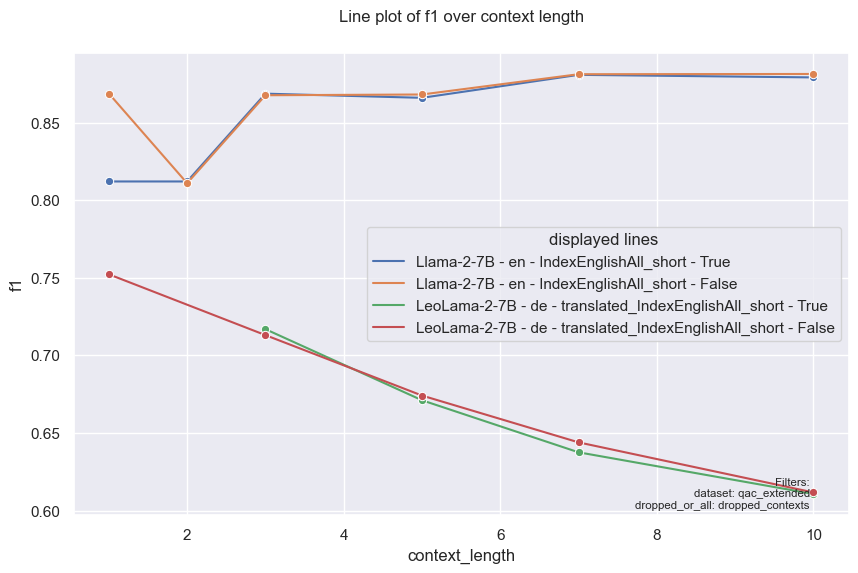

In [43]:
# Graph 3
# Can the reader identify if the correct context was not provided?

selected_indices = [ "IndexEnglishAll_short", "translated_IndexEnglishAll_short"]
selected_readers = ["Llama-2-7B", "LeoLama-2-7B"]
random_shuffles = ["True", "False"]
dropped_or_all = ["dropped_contexts"]
language = ["en", "de"]
selected_datasets = ["qac_extended"]

# metric_keys = ["llm_accuracy", "accuracy"]  # Only one metric key is needed for the x-axis
metric_keys = ["bertscore", "f1"]
generate_lineplot(data, selected_indices=selected_indices, selected_readers=selected_readers, random_shuffles=random_shuffles, dropped_or_all=dropped_or_all, language=language, selected_datasets=selected_datasets, metric_keys=metric_keys)

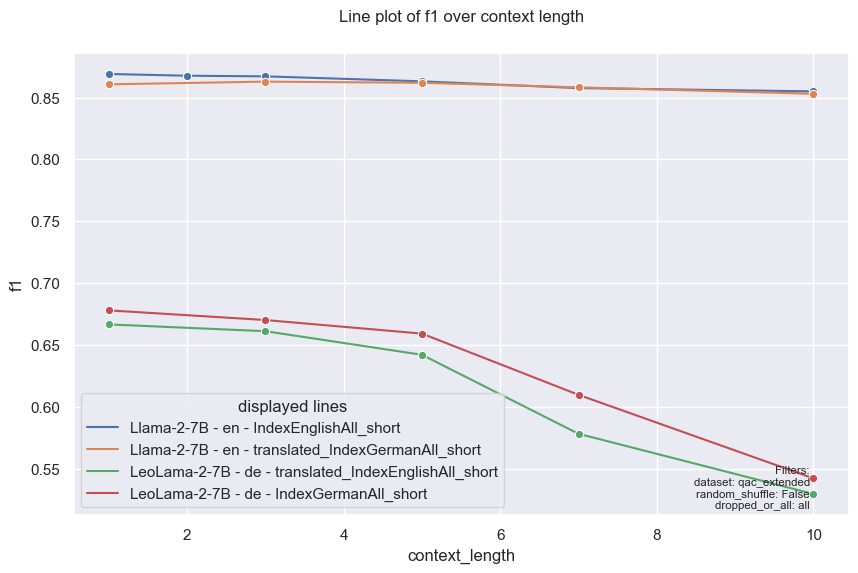

In [44]:
# Graph 4
# How much do the models differ in language skills?


selected_indices = [ "IndexEnglishAll_short", "translated_IndexEnglishAll_short", "IndexGermanAll_short", "translated_IndexGermanAll_short"]
selected_readers = ["Llama-2-7B", "LeoLama-2-7B"]
random_shuffles = ["False"]
dropped_or_all = ["all"]
language = ["en", "de"]
selected_datasets = ["qac_extended"]

# metric_keys = ["llm_accuracy", "accuracy"]  # Only one metric key is needed for the x-axis
metric_keys = ["bertscore", "f1"]
generate_lineplot(data, selected_indices=selected_indices, selected_readers=selected_readers, random_shuffles=random_shuffles, dropped_or_all=dropped_or_all, language=language, selected_datasets=selected_datasets, metric_keys=metric_keys)

In [ ]:
# Graph 5
# Hom much better is OpenAI compared to the other models?

In [328]:
# Graph 6 (Data Quality)
# How much does the gold-answer-generation performance differ between the models?

# No graph needed, just look at other graphs context length = 1